In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np

In [2]:


DTYPE=torch.float

torch.manual_seed(734)
print("Feedforward SNN Trained on MNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=128
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True,drop_last=True)

Feedforward SNN Trained on MNIST
Using device: cuda


Use a connectivity percentage as it's easier to calculate\
given $\theta_k \leftarrow \theta_k - \eta \frac{\partial}{\partial \theta_k} \mathbb{E}_{X, Y^*}(\theta) - \eta \alpha + \sqrt{2\eta T} \nu_k$,\
$-\eta \frac{\partial}{\partial \theta_k} \mathbb{E}_{X, Y^*}(\theta)$ is already applied during the backward pass.\
Therefore in our training loop we need to apply $- \eta \alpha + \sqrt{2\eta T} \nu_k$ to connection weights.

Also we can combine the sign and mask matrix into one where we have each element either 1/-1 for the sign or 0 if inactive.

In [3]:
################ MNIST Model ##############################################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 300
num_hidden2 = 100
num_outputs = 10
num_steps = 26  # for spike encoding
beta = 0.95 #leak rate
lr=5e-3
#weight_decay=1e-6

spike_grad1 = surrogate.atan()

class WeightMasker(nn.Module):

    #TODO send tensors to CUDA

    def __init__(self, linearsList : nn.ModuleList, learnRate, temp = 1e-5, alpha = 1e-5, connectivity = 0.07):
        super().__init__()
        self.learnRate = learnRate
        self.regulariser = alpha * learnRate
        self.noiseTemp = temp
        self.connectivity = connectivity
        self.weightSignMasks = [] #element of 1/-1 means connection active
        self.flipTrack = []
        self.linearsList = linearsList

        with torch.no_grad(): #is this needed?
        #initialise with weight connectivity %
            for i in self.linearsList:
                print("initial zero weights:",torch.sum(i.weight==0).item())
                weightMask = torch.bernoulli(torch.full_like(i.weight,self.connectivity,dtype=DTYPE,device=device))

                i.weight.data = i.weight * weightMask #hadamard product
                self.weightSignMasks.append( torch.sign(i.weight) * weightMask)

                self.flipTrack.append(torch.zeros_like(i.weight,dtype=DTYPE, device=device))


    def deepr_update(self):
        if not self.training: return
        with torch.no_grad():
            for i in range(len(self.linearsList)):
                (new_w,new_wsm) = self.rewiring(self.linearsList[i].weight,self.weightSignMasks[i])
                self.linearsList[i].weight.data=new_w #dont use weight = nn.Parameter, or it goes haywire
                self.weightSignMasks[i]=new_wsm

    def rewiring(self, weights: torch.tensor, weightSignMask: torch.tensor):
        #add regularisation and noise
        #weightDiff = torch.randn_like(weights,dtype=DTYPE,device=device)*((2*self.learnRate*self.noiseTemp)**0.5) #- self.regulariser
        #weights = weights + weightDiff

        #remove connections below threshold
        remove_weights = ((weights * weightSignMask) >= 0)
        
        weightSignMask = weightSignMask * remove_weights

        #set disabled weights to zero
        weightMask = torch.abs(weightSignMask)
        weights = weights * weightMask

        #calculate connections to activate
        connection_count = torch.numel(weightMask)
        to_activate = int( (self.connectivity - (weightMask.sum()/connection_count) ) * connection_count )

        if to_activate>0:
            zero_indexes = torch.nonzero(weightMask == 0)

            #randomly select disabled weights
            zero_ind_ind = torch.randint(0, zero_indexes.size(0), (to_activate,), device=device) #this produces indexes of the zero indexes list TODO use randint
            

            selected_weights = zero_indexes[zero_ind_ind]

            #enable weights selected with a random sign
            new_signs = ((torch.rand(to_activate,device=device) < 0.5).float() - 0.5) * 2
            weightSignMask[selected_weights[:,0],selected_weights[:,1]] = new_signs

            #assign initial values to weights equal to the learning rate
            weights[selected_weights[:,0],selected_weights[:,1]] = new_signs * self.learnRate

        return (weights, weightSignMask)

class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        self.linears = nn.ModuleList([
            nn.Linear(num_inputs, num_hidden1),
            nn.Linear(num_hidden1,num_hidden2),
            nn.Linear(num_hidden2,num_outputs)
        ])

        

        # initialize neurons
        self.neurons = nn.ModuleList([
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1)
        ])

        self.to(device)

        self.weightMasker = WeightMasker(self.linears,lr)

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

  
    def forward(self,x): #x is input data

        #spike encoding at input layer
        x_spk = spikegen.latency(x,num_steps=num_steps) 
        # Initialize hidden states
        
        mem1 = self.neurons[0].init_leaky()
        mem2 = self.neurons[1].init_leaky()
        mem3 = self.neurons[2].init_leaky()
        
        mems = []
        for n in self.neurons:
            mems.append(n.init_leaky())

        # record spike outputs and membrane potentials
        mem3_rec = []
        spk3_rec = []

        for step in range(num_steps):
            x = x_spk[step] #for encoded input

            cur1 = self.linears[0](x)
            spk1, mem1 = self.neurons[0](cur1, mem1)

            cur2 = self.linears[1](spk1)
            spk2, mem2 = self.neurons[1](cur2, mem2)

            cur3 = self.linears[2](spk2)
            spk3, mem3 = self.neurons[2](cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
    
###################################################################################



initial zero weights: 0
initial zero weights: 0
initial zero weights: 0
Epoch 0, Iteration 0, Minibatch stats:
    Train Set Loss: 2.30
    Test Set Loss: 2.30
    Accuracy: 12.50%
    Accuracy: 8.59%


Epoch 0, Iteration 50, Minibatch stats:
    Train Set Loss: 2.14
    Test Set Loss: 2.15
    Accuracy: 28.12%
    Accuracy: 26.56%


Epoch 0, Iteration 100, Minibatch stats:
    Train Set Loss: 0.84
    Test Set Loss: 0.69
    Accuracy: 74.22%
    Accuracy: 73.44%


Epoch 0, Iteration 150, Minibatch stats:
    Train Set Loss: 0.46
    Test Set Loss: 0.46
    Accuracy: 82.81%
    Accuracy: 87.50%


Epoch 0, Iteration 200, Minibatch stats:
    Train Set Loss: 0.46
    Test Set Loss: 0.45
    Accuracy: 85.94%
    Accuracy: 84.38%


Epoch 0, Iteration 250, Minibatch stats:
    Train Set Loss: 0.34
    Test Set Loss: 0.38
    Accuracy: 91.41%
    Accuracy: 89.06%


Epoch 0, Iteration 300, Minibatch stats:
    Train Set Loss: 0.34
    Test Set Loss: 0.31
    Accuracy: 89.84%
    Accuracy: 88.

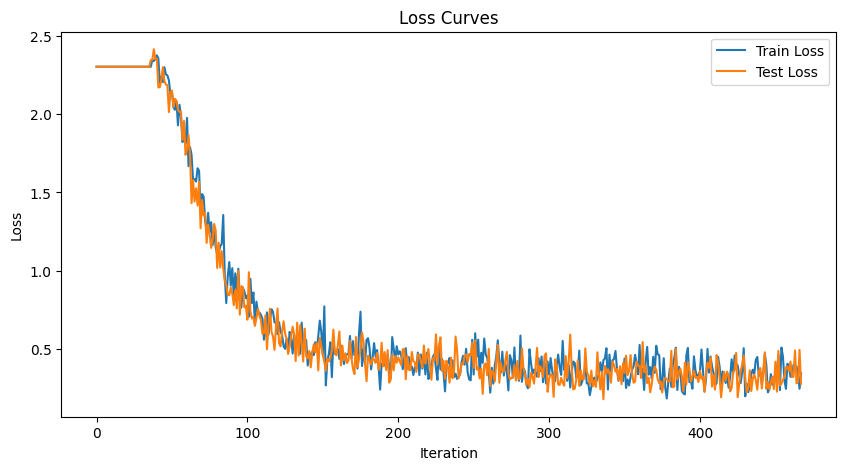

Test Set: 
    Accuracy: 89.59%


In [4]:
########### STATS ##############

def print_stats(data, targets):
    output, _ = net(data.view(data.size(0), -1))
    acc  = net.accuracy_metric(output, targets)
    #dev = np.std((targets == idx).detach().cpu().numpy()) #TODO deviation for latency encoding
    print(f"    Accuracy: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {img_counter}, Minibatch stats:")
    print(f"    Train Set Loss: {loss_hist[batch_counter]:.2f}")
    print(f"    Test Set Loss: {test_loss_hist[img_counter]:.2f}")
    print_stats(data, targets)
    print_stats(test_data, test_targets)
    print("\n")


##############################


# Load the network onto CUDA
net = Net().to(device)

loss = functional.loss.ce_rate_loss()
optimiser = torch.optim.Adam(net.parameters(),lr=lr)

num_epochs = 1
loss_hist = []
test_loss_hist = []

img_counter = 0 #total no. of images iterated over

#training loop
for epoch in range(num_epochs):
    batch_counter=0 #image number within current batch

    train_batches = iter(train_loader)

    #mini-batch loop
    for data, targets in train_batches: #torch.Size([128, 1, 28, 28]), torch.Size([128])

        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train() #inform pytorch
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        #calculate loss as cross entropy of membrane potential at each step
        loss_val = net.loss(spk_rec,targets)

        
        optimiser.zero_grad() #(reset for batch)
        loss_val.backward() #calculate backpropogation error gradient
        optimiser.step() #then update parameters

        net.weightMasker.deepr_update() #then apply deepr

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad(): #tell pytorch to disable gradient calculation (save compute)
            net.eval()

            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = net.loss(test_spk,test_targets)
            test_loss_hist.append(test_loss.item())
            # Print train/test loss/accuracy
            if img_counter % 50 == 0:
                train_printer()
            img_counter += 1
            batch_counter +=1


###############################################################################################

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    print("Test Set: ")
    print_stats(data,targets)

###TODO: change loss functions, latency encoding,
# can we implement STDP?

#Notes:
#training time is almost double

torch.save(net.state_dict(),"./SNN_deepr.model")

In [5]:
net = Net()
net.load_state_dict(torch.load("./SNN_deepr.model"))

torch.sum(torch.abs(net.linears[2].weight))/torch.numel(net.linears[2].weight)
#sparsity of final layer below 5%?

initial zero weights: 0
initial zero weights: 0
initial zero weights: 0


RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for neurons.0.mem: copying a param with shape torch.Size([10000, 300]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for neurons.1.mem: copying a param with shape torch.Size([10000, 100]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for neurons.2.mem: copying a param with shape torch.Size([10000, 10]) from checkpoint, the shape in current model is torch.Size([1]).

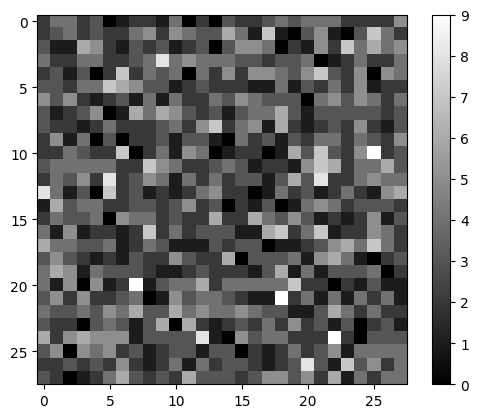

In [ ]:
### visualisation of the first layer

connected0 = torch.abs(net.weightMasker.weightSignMasks[0].cpu()).sum(dim=0).view(28,28)

plt.imshow(connected0, cmap='gray', interpolation='nearest')
plt.colorbar()

